<a href="https://colab.research.google.com/github/Sara1041/Thesis/blob/main/Classification_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt

In [ ]:
import os
import cv2

image_size = 96

def get_data(df):
    data = list()
    y = list()

    for index, row in df.iterrows():
        img_arr = cv2.imread(row['img_path'], cv2.IMREAD_GRAYSCALE)
        resized_array = cv2.resize(img_arr, (image_size, image_size))
        data.append(resized_array)
        y.append(0 if row['gender'] == 'F' else 1)
    return np.expand_dims(np.array(data), 3), np.array(y)

In [ ]:
import pandas as pd

df = pd.read_csv('finger_alt.csv')
trainX, trainY = get_data(df)
print("Total number of Train image", len(trainX))

Total number of Train image 55270


In [ ]:
trainX = trainX / 255
# trainY = trainY - 1

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=.1, random_state=seed, stratify=trainY)

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.layers import Input, Concatenate

img_input = Input(shape=(image_size, image_size, 1))
img_conc = Concatenate()([img_input, img_input, img_input])
model = EfficientNetV2S(input_tensor=img_conc, include_top=False, weights='imagenet')

model_name = 'EfficientNetV2S'

2023-01-08 09:27:54.220471: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 09:27:54.221068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:27:54.221256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 09:27:54.221394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

82420632/82420632 [==============================] - 24s 0us/step


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
headModel = model.output
headModel = Flatten()(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=model.input, outputs=headModel)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-5)
loss = 'binary_crossentropy'
metrics = ['accuracy', 'Precision', 'Recall']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100

callbacks = [
    EarlyStopping(patience=5, monitor='val_accuracy'),
]
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=epochs, validation_split=.2, callbacks=callbacks)

2023-01-08 09:28:25.691985: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1466966016 exceeds 10% of free system memory.
2023-01-08 09:28:26.401959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1466966016 exceeds 10% of free system memory.


Epoch 1/100


2023-01-08 09:28:45.363945: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-01-08 09:28:46.804262: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1244/1244 [==============================] - 116s 77ms/step - loss: 0.4715 - accuracy: 0.7953 - precision: 0.8165 - recall: 0.9599 - val_loss: 0.4172 - val_accuracy: 0.8217 - val_precision: 0.8366 - val_recall: 0.9657
Epoch 2/100
1244/1244 [==============================] - 90s 72ms/step - loss: 0.4087 - accuracy: 0.8229 - precision: 0.8407 - recall: 0.9607 - val_loss: 0.3718 - val_accuracy: 0.8417 - val_precision: 0.8555 - val_recall: 0.9652
Epoch 3/100
1244/1244 [==============================] - 92s 74ms/step - loss: 0.3635 - accuracy: 0.8439 - precision: 0.8605 - recall: 0.9604 - val_loss: 0.3260 - val_accuracy: 0.8621 - val_precision: 0.8795 - val_recall: 0.9590
Epoch 4/100
1244/1244 [==============================] - 93s 75ms/step - loss: 0.3130 - accuracy: 0.8689 - precision: 0.8832 - recall: 0.9635 - val_loss: 0.2748 - val_accuracy: 0.8884 - val_precision: 0.9124 - val_recall: 0.9520
Epoch 5/100
1244/1244 [==============================] - 91s 73ms/step - loss: 0.2632 - accurac

In [ ]:
model.evaluate(X_test, y_test);

173/173 [==============================] - 5s 14ms/step - loss: 0.0129 - accuracy: 0.9958 - precision: 0.9980 - recall: 0.9968


In [ ]:
y_true = y_test.ravel()
y_pred = model.predict(X_test).round().ravel()
# y_pred = np.argmax(y_pred)

173/173 [==============================] - 5s 13ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9874    0.9919    0.9896      1107
           1     0.9980    0.9968    0.9974      4420

    accuracy                         0.9958      5527
   macro avg     0.9927    0.9944    0.9935      5527
weighted avg     0.9958    0.9958    0.9958      5527



In [ ]:
history = history.history

In [ ]:
%pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


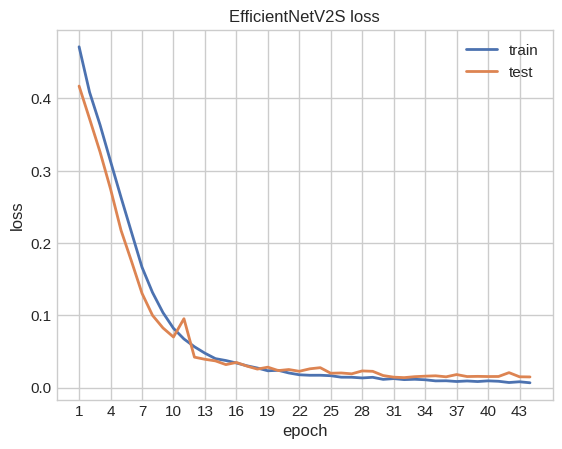

In [ ]:
import seaborn as sns
sns.set(font_scale=1)
plt.style.use('seaborn-whitegrid')
n = len(history['loss'])
plt.plot(range(1, n+1), history['loss'], linewidth=2)
plt.plot(range(1, n+1), history['val_loss'], linewidth=2)
plt.xticks(range(1, n+1, 3))
plt.title(f'{model_name} loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(f'plots/loss_gender_{model_name}.png', dpi=200, bbox_inches='tight')

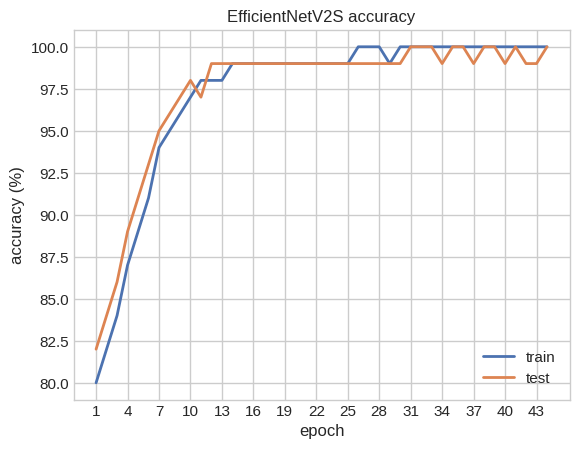

In [ ]:
sns.set(font_scale=1)
r = lambda x: round(x*100)
plt.style.use('seaborn-whitegrid')
n = len(history['loss'])
plt.plot(range(1, n+1), [r(x) for x in history['accuracy']], linewidth=2)
plt.plot(range(1, n+1), [r(x) for x in history['val_accuracy']], linewidth=2)
plt.xticks(range(1, n+1, 3))
plt.title(f'{model_name} accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig(f'plots/accuracy_gender_{model_name}.png', dpi=200, bbox_inches='tight')